## Cubic regularization

We want to minimize
$$\min_{x\in {\mathbb R}^{d}} f(x)=g^\top x + \frac{1}{2} x^\top H x + \frac{M}{6}\|x\|^3,$$
where $g\in {\mathbb R}^{d}$, $H\in {\mathbb R}^{d\times d}$ and $M>0$ are given
The gradient is given by $\nabla f(x) = g + H x + \frac{M \|x\|}{2}x$.

This function is smooth only locally, so to make GD and Nesterov's acceleration work, we need to tune the stepsize.

For this experiment in the paper we used covtype dataset from the [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) library, but since its size is ~90 Mb, below we changed it to mushrooms.

In [1]:
import matplotlib
import numpy as np
import seaborn as sns
import scipy

import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file

from optimizers import Gd, Nesterov, Adgd, AdgdAccel
from loss_functions import cubic_loss, cubic_gradient, logistic_gradient

sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
data_path = './datasets/covtype.bz2'
markers = [',', 'o', '*', 'D']
labels = ['GD', 'Nesterov', 'AdGD', 'AdGD-accel']

it_max = 1000

In [2]:
from sklearn.utils.extmath import safe_sparse_dot

def logistic_hessian(w, X, y, l2):
    activation = scipy.special.expit(safe_sparse_dot(X, w, dense_output=True).ravel())
    weights = activation * (1 - activation)
    X_weights = X.T * weights
    return X_weights @ X + l2 * np.eye(len(w))

In [3]:
def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))

In [21]:
data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Loss functions support only labels from {0, 1}
    y -= 1
n, d = X.shape
L = logistic_smoothness(X)
scale = L * n
l2 = 0

w0 = np.zeros(d)
g = logistic_gradient(w0, X, y, l2, normalize=False)
H = logistic_hessian(w0, X, y, l2)

"""
The value of M should be chosen proportionally to L and n, but we instead
use 'scale' variable when computing gradients and loss values
"""
M = 100

def loss_func(w):
    return cubic_loss(w, H, g, M, scale)

def grad_func(w):
    return cubic_gradient(w, H, g, M, scale)

In [30]:
lrs = np.logspace(-1, 1, 10)
losses = []
"""
    Tune the stepsize
Since the method might solve the problem up to machine
precision faster than it_max, it's better to use it_max // 2
"""
for lr_gd in lrs:
    gd = Gd(lr=lr_gd, loss_func=loss_func, grad_func=grad_func, it_max=it_max // 2)
    gd.run(w0=w0)
    gd.compute_loss_on_iterates()
    print(lr_gd, gd.losses[-1])
    losses.append(gd.losses[-1])
lr_gd = lrs[np.nanargmin(losses)]
gd = Gd(lr=lr_gd, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gd.run(w0=w0)

0.1 -6971.811225375406
0.16681005372000587 -7005.502489919728
0.2782559402207124 -7019.273926091584
0.46415888336127786 -7021.920819794649
0.774263682681127 -7022.058775632453
1.291549665014884 -7022.059807704445
2.1544346900318834 nan
3.593813663804626 nan
5.994842503189409 nan
10.0 nan


/Users/mishchk/research/adaptive_GD/loss_functions.py:92: RuntimeWarning: invalid value encountered in matmul
  return (g+H@w)/scale + M/2*w*la.norm(w)
/Users/mishchk/research/adaptive_GD/loss_functions.py:84: RuntimeWarning: overflow encountered in matmul
  return w@g + 0.5*H@w@w + scale*M/6*la.norm(w)**3
/Users/mishchk/research/adaptive_GD/loss_functions.py:84: RuntimeWarning: invalid value encountered in matmul
  return w@g + 0.5*H@w@w + scale*M/6*la.norm(w)**3
/Users/mishchk/research/adaptive_GD/loss_functions.py:84: RuntimeWarning: overflow encountered in double_scalars
  return w@g + 0.5*H@w@w + scale*M/6*la.norm(w)**3


In [31]:
lrs = np.logspace(-1, 1, 10)
losses = []
#tune the stepsize
for lr_nest in lrs:
    nest = Nesterov(lr=lr_nest, loss_func=loss_func, grad_func=grad_func, it_max=it_max // 2)
    nest.run(w0=w0)
    nest.compute_loss_on_iterates()
    print(lr_nest, nest.losses[-1])
    losses.append(nest.losses[-1])
lr_nest = lrs[np.nanargmin(losses)]
nest = Nesterov(lr=lr_nest, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest.run(w0=w0)

0.1 -7022.032287678336
0.16681005372000587 -7022.054715468566
0.2782559402207124 -7022.0584619501205
0.46415888336127786 -7022.059753872376
0.774263682681127 -7022.05980677118
1.291549665014884 -7022.059808122952
2.1544346900318834 nan
3.593813663804626 nan
5.994842503189409 nan
10.0 nan


/Users/mishchk/research/adaptive_GD/loss_functions.py:92: RuntimeWarning: overflow encountered in matmul
  return (g+H@w)/scale + M/2*w*la.norm(w)


In [32]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)

/Users/mishchk/research/adaptive_GD/optimizers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)


In [33]:
ad_acc = AdgdAccel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ad_acc.run(w0=w0)

/Users/mishchk/research/adaptive_GD/optimizers.py:131: RuntimeWarning: invalid value encountered in double_scalars
  L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)


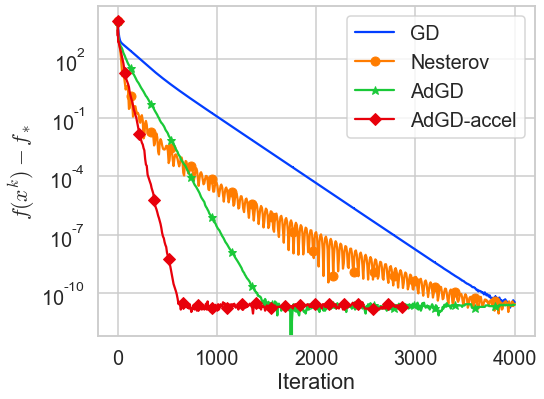

In [26]:
optimizers = [gd, nest, adgd, ad_acc]
for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
for opt, marker, label in zip(optimizers, markers, labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend() 
plt.tight_layout()
plt.show()